<a href="https://colab.research.google.com/github/jdavidd/FashionMNIST-model/blob/master/FashionMNIST_CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
from skimage import transform
import torchvision.transforms as transforms
from torch.autograd import Variable
import pandas as pd;
import numpy as np;
from torch.utils.data import Dataset, DataLoader
#from vis_utils import *
import random;
import math;
import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
df_train = pd.read_csv('/content/gdrive/My Drive/FashionMnist/fashionmnist/fashion-mnist_train.csv')
df_test = pd.read_csv('/content/gdrive/My Drive/FashionMnist/fashionmnist/fashion-mnist_test.csv')

In [0]:
df_train = df_train.values
df_test = df_test.values


In [0]:
train_x = df_train[:,1:785]
train_y = df_train[:,0]

test_x = df_test[:,1:785]
test_y = df_test[:,0]

In [0]:
train_x = train_x.reshape((-1,28,28))
test_x = test_x.reshape((-1,28,28))


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


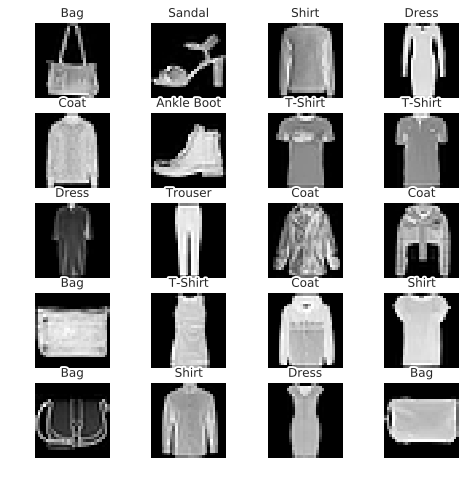

In [0]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};

fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;

for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_x));
    img = train_x[img_xy,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_y[img_xy]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [0]:
train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)
test_x = torch.from_numpy(test_x)
test_y = torch.from_numpy(test_y)


In [0]:
class FashionMNISTDataset(Dataset):
    '''Fashion MNIST Dataset'''
    def __init__(self, t_x, t_y, transform=None):
        self.X = t_x
        self.Y = t_y
        self.transform = transform
    def __len__(self):
        return len(self.X);
    
    def __getitem__(self, idx):
        item = self.X[idx];
        label = self.Y[idx];
        
        if self.transform:
            item = self.transform(np.float32(item));
        
        return (item, label);

In [0]:
#Use this for data augmentation
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

In [0]:
batch_size = 100;
train_dataset = FashionMNISTDataset(train_x, train_y, transform_train)
test_dataset = FashionMNISTDataset(test_x,test_y)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True);
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True);

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [0]:
no_filters1 = 32
no_filters2 = 64
no_filters3 = 128
no_filters4 = 256

no_neurons1 = 512
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, no_filters1, 3, 1, 1)
        self.conv2 =  nn.Conv2d(no_filters1, no_filters1, 3, 1, 1)
        
        self.conv3 = nn.Conv2d(no_filters1,no_filters2, 3, 1, 1)
        self.conv4 =  nn.Conv2d(no_filters2, no_filters2, 3, 1, 1)
        
        self.conv5 = nn.Conv2d(no_filters2,no_filters3, 3, 1, 1)
        self.conv6 =  nn.Conv2d(no_filters3, no_filters3, 3, 1, 1)

        self.conv7 =  nn.Conv2d(no_filters3, no_filters4, 3, 1, 1)
        self.conv8 = nn.Conv2d(no_filters4,no_filters4, 3, 1, 1)
        self.conv9 =  nn.Conv2d(no_filters4, no_filters4, 3, 1, 1)
        
        self.fc1 =  nn.Linear(1*1*no_filters4,no_neurons1)
        self.fc2 =  nn.Linear(no_neurons1,no_neurons1)
        self.fc3 =  nn.Linear(no_neurons1,10)
        
        self.drop_layer = nn.Dropout(0.5)
    def forward(self, x):
        x = x.reshape(-1,1,28,28)
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x,2,2)

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.max_pool2d(x,2,2)

        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.max_pool2d(x,2,2)

        x = x.view(-1,1*1*no_filters4)

        x = F.relu(self.fc1(x))
        x = self.drop_layer(x)
        x = F.relu(self.fc2(x))
        x = self.drop_layer(x)
        
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [0]:
no_filters1 = 32
no_filters2 = 64
no_neurons1 = 500
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, no_filters1, 5, 1)
        self.conv2 =  nn.Conv2d(no_filters1, no_filters2, 3, 1)
        self.fc1 =  nn.Linear(5*5*no_filters2,no_neurons1)
        self.fc2 =  nn.Linear(no_neurons1,10)
    def forward(self, x):
        x = x.reshape(-1,1,28,28)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        print(x.shape)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        print(x.shape)
        x = x.view(-1,5*5*no_filters2)
        print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [0]:
num_epochs = 10;
batch_size = 100;
learning_rate = 0.0002
cnn = CNN();
cnn.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr = learning_rate)

In [0]:
train_loss = []  
j = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # Forward + Backward + Optimize
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = cnn(images.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.cpu().detach().numpy())
        
        if (i+1) % 100 == 0:
            print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, train_loss[j]))
        j = j + 1

Epoch : 1/10, Iter : 100/600,  Loss: 1.0924
Epoch : 1/10, Iter : 200/600,  Loss: 0.7432
Epoch : 1/10, Iter : 300/600,  Loss: 0.5290
Epoch : 1/10, Iter : 400/600,  Loss: 0.5173
Epoch : 1/10, Iter : 500/600,  Loss: 0.4038
Epoch : 1/10, Iter : 600/600,  Loss: 0.4293
Epoch : 2/10, Iter : 100/600,  Loss: 0.4841
Epoch : 2/10, Iter : 200/600,  Loss: 0.3170
Epoch : 2/10, Iter : 300/600,  Loss: 0.4221
Epoch : 2/10, Iter : 400/600,  Loss: 0.3912
Epoch : 2/10, Iter : 500/600,  Loss: 0.3555
Epoch : 2/10, Iter : 600/600,  Loss: 0.3078
Epoch : 3/10, Iter : 100/600,  Loss: 0.3539
Epoch : 3/10, Iter : 200/600,  Loss: 0.3964
Epoch : 3/10, Iter : 300/600,  Loss: 0.4033
Epoch : 3/10, Iter : 400/600,  Loss: 0.3931
Epoch : 3/10, Iter : 500/600,  Loss: 0.3415
Epoch : 3/10, Iter : 600/600,  Loss: 0.3207
Epoch : 4/10, Iter : 100/600,  Loss: 0.3430
Epoch : 4/10, Iter : 200/600,  Loss: 0.4018
Epoch : 4/10, Iter : 300/600,  Loss: 0.3566
Epoch : 4/10, Iter : 400/600,  Loss: 0.2305
Epoch : 4/10, Iter : 500/600,  L

(6000,)


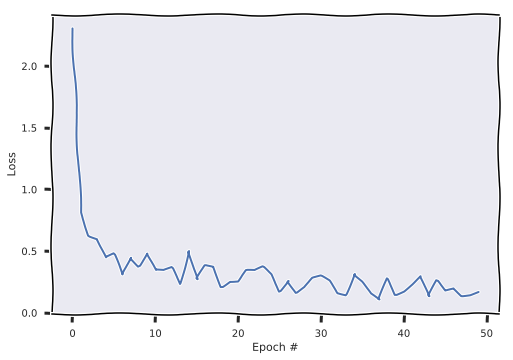

In [0]:
from numpy import array
t = train_loss
t = array(t)
l = t[0::120]
print(t.shape)
plt.xkcd()
plt.xlabel('Epoch #');
plt.ylabel('Loss');
plt.plot(l);
plt.show();

In [0]:
test_loss = []
cnn.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.float())
    images = images.to(device)
    labels = labels.to(device)
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    loss = criterion(outputs, labels)
    test_loss.append(loss.cpu().detach().numpy())
print(correct)
print('Test Accuracy of the model on the 10000 test images: %.4f %%' % (float(100 * correct) / float(total)))
#91,94 lr 0.001
#92,73 lr 0.0025

tensor(9264, device='cuda:0')
Test Accuracy of the model on the 10000 test images: 92.6400 %


(100,)


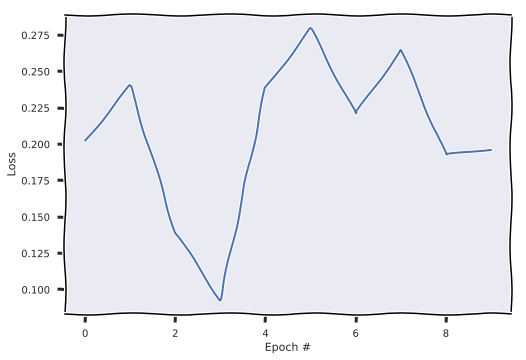

In [0]:
t = test_loss
t = array(t)
l = t[0::10]
print(t.shape)
plt.xkcd()
plt.xlabel('Epoch #');
plt.ylabel('Loss');
plt.plot(l);
plt.show();